In [1]:
import cv2
import sys
import numpy as np
from random import randint as randi
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [104]:
#importa a imagem para ser processada e reduz o tamanho dela
img_original = cv2.imread('/content/face6.png',1)
img = cv2.resize(img_original, None, fx=0.25, fy=0.25)

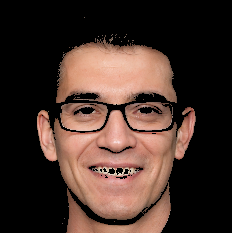

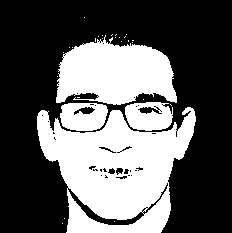

True

In [106]:
#funcao do algoritmo de Skin color thresholding
def isSkin(B, G, R):
  if (R > 95 and G > 40 and B > 20 and
          R > G and R > B and abs(R - G) > 15 and
          (max(R, G, B) - min(R, G, B)) > 15):
        Y = 0.299*R + 0.587*G+0.114*B
        Cb= -0.1687*R - 0.3313*G + 0.5*B + 128
        Cr = 0.5*R - 0.4187*G - 0.0813*B + 128
        if(Cr <= 1.5862*Cb + 20 and Cr >= 0.3448*Cb + 76.2069 and
           Cr >= -4.5652*Cb + 234.5652 and Cr <= -1.15*Cb + 301.75 and
           Cr <= -2.2857*Cb + 432.85):
             return True
  return False

def skin_thresholding(img, color = 1):
  output = np.zeros(img.shape, dtype=np.uint8)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      B, G, R = img[i, j]

      if(isSkin(B, G, R)):
        if(color):
          output[i, j] = img[i, j]
        else:
          output[i, j] = [255, 255, 255]

  return output

img_filtered = skin_thresholding(img)
cv2_imshow(img_filtered)
cv2.imwrite("skin.png", img_filtered)
img_filtered_mask = skin_thresholding(img,0)
cv2_imshow(img_filtered_mask)
cv2.imwrite("skin_mask.png", img_filtered_mask)

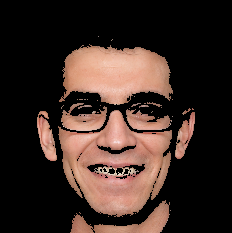

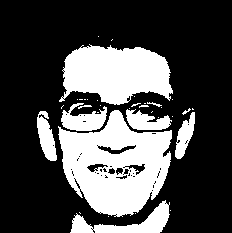

In [105]:
#funcoes para o algoritmo de K-means
def bgr2hex(bgr):
   return "#%02x%02x%02x" % (int(bgr[2]), int(bgr[1]), int(bgr[0]))

def ScatterPlot(img, centroids, clutserLabels, plotNameOut="scatterPlot.png"):
    fig = plt.figure()
    ax = Axes3D(fig)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            ax.scatter(img[x, y, 2], img[x, y, 1], img[x, y, 0], color = bgr2hex(centroids[clutserLabels[x, y]]))
    plt.show()
    plt.savefig(plotNameOut)

def ShowCluster(img, centroids, clusterLabels, imgNameOut="out.png"):
   result = np.zeros((img.shape), dtype=np.uint8)
   for i in range(img.shape[0]):
       for j in range(img.shape[1]):
           bgr = centroids[clusterLabels[i, j]]
           result[i, j, 0] = np.uint8(bgr[0])
           result[i, j, 1] = np.uint8(bgr[1])
           result[i, j, 2] = np.uint8(bgr[2])
   cv2.imwrite(imgNameOut, result)
   #some problem - it's not necessary
   #TODO
   #ScatterPlot(img, centroids, clusterLabels, plotNameOut="scatterPlot.png")
   cv2_imshow(result)
   cv2.imwrite(imgNameOut, result)

def GetEuclideanDistance(Cbgr, Ibgr):
   b = float(Cbgr[0]) - float(Ibgr[0])
   g = float(Cbgr[1]) - float(Ibgr[1])
   r = float(Cbgr[2]) - float(Ibgr[2])
   return math.sqrt(b * b + g * g + r * r)

def KMeansSkinSegmentation(img, k, max_iterations=100, imgNameOut="out.png", color=1):

   Clusters = k
   # create the centroids of algorithm - each k is there is a center called "centroid"
   centroids = np.zeros((k, 3), dtype=np.float64)  #for 5D, create a matrix of zeros with (k, 5)
   for i in range(Clusters):
      #start get the initial point of segmentation in X and Y coordinates
      x = randi(0, img.shape[0]-1)
      y = randi(0, img.shape[1]-1)
      #get the RGB (BGR) from img and divide in different matrix
      b = float(img[x, y, 0])
      g = float(img[x, y, 1])
      r = float(img[x, y, 2])

      centroids[i, 0] = b
      centroids[i, 1] = g
      centroids[i, 2] = r
      #centroids[i, 3] = x
      #centroids[i, 4] = y
      #in 5D add too x and y in centroids


   ClusterLabels = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
   for iteration in range(max_iterations):
       for x in range(img.shape[0]):
           for y in range(img.shape[1]):
               B, G, R = img[x, y]
               MinDist = sys.float_info.max

               # Ajuste de condição similar ao threshold para ajudar o KMeans a focar em pele
               if (isSkin(B, G, R)):
                   for c in range(k):
                       dist = GetEuclideanDistance(centroids[c], img[x, y])
                       if dist <= MinDist:
                           MinDist = dist
                           ClusterLabels[x, y] = c

       MeanCluster = np.zeros((Clusters, 4), dtype=np.float64)
       for x in range(img.shape[0]):
           for y in range(img.shape[1]):
               clusterNumber = ClusterLabels[x, y]
               MeanCluster[clusterNumber, 0] += 1
               MeanCluster[clusterNumber, 1] += float(img[x, y, 0])
               MeanCluster[clusterNumber, 2] += float(img[x, y, 1])
               MeanCluster[clusterNumber, 3] += float(img[x, y, 2])

       # Atualização dos centróides
       copy = np.copy(centroids)
       for c in range(Clusters):
           if MeanCluster[c, 0] > 0:
               centroids[c, 0] = MeanCluster[c, 1] / MeanCluster[c, 0]
               centroids[c, 1] = MeanCluster[c, 2] / MeanCluster[c, 0]
               centroids[c, 2] = MeanCluster[c, 3] / MeanCluster[c, 0]

       if np.allclose(centroids, copy):
           break

   result = np.zeros(img.shape, dtype=np.uint8)
   for i in range(img.shape[0]):
       for j in range(img.shape[1]):
           if ClusterLabels[i, j] == 1:  # Segmento de pele
            if(color):
               result[i, j] = img[i,j]
            else: result[i, j] = [255, 255, 255]

   cv2.imwrite(imgNameOut, result)
   cv2_imshow(result)

KMeansSkinSegmentation(img, 2, 100, "img_kmeans.png", 1)
KMeansSkinSegmentation(img, 2, 100, "img_kmeans_mask.png", 0)

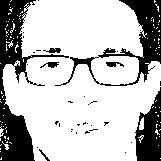

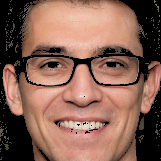

True

In [107]:
#funcao para o algoritmo de SEEDS do OpenCV
def segment_skin_using_seeds(image):
    # Carregar o classificador Haar para detecção de face
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Converter para escala de cinza apenas para detecção de rosto
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Verificar se uma face foi detectada
    if len(faces) == 0:
        print("Nenhuma face detectada.")
        return None

    # Suponha que temos uma face (pegue a primeira face detectada)
    x, y, w, h = faces[0]
    face_region = image[y:y+h, x:x+w]

    # Configurações do algoritmo SEEDS
    height, width, _ = face_region.shape
    seeds = cv2.ximgproc.createSuperpixelSEEDS(width, height, face_region.shape[2], num_superpixels=400, num_levels=4, prior=2)

    # Aplicar SEEDS na região de rosto em BGR
    seeds.iterate(face_region, num_iterations=100)
    # Obter a máscara de superpixels e segmentar a região da pele
    mask_seeds = seeds.getLabelContourMask()
    # Obter os rótulos de superpixel
    labels_seeds = seeds.getLabels()

    # Filtrar pixels de pele pela cor usando HSV
    hsv_face = cv2.cvtColor(face_region, cv2.COLOR_BGR2HSV)
    lower_skin = np.array([0, 20, 70], dtype=np.uint8)
    upper_skin = np.array([20, 255, 255], dtype=np.uint8)
    skin_mask = cv2.inRange(hsv_face, lower_skin, upper_skin)

    cv2_imshow(skin_mask)
    cv2.imwrite("seeds_mask.png", skin_mask)

    # Aplicar a máscara de pele sobre os superpixels
    skin_area = cv2.bitwise_and(face_region, face_region, mask=skin_mask)

    return skin_area

# Carregar uma imagem de exemplo
img_final = segment_skin_using_seeds(img)

# Exibir a imagem final
cv2_imshow(img_final)
cv2.imwrite("seeds.png", img_final)